In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
import pandas as pd
import tarfile
import json
import tqdm

from scipy.stats import beta

from statsmodels.stats.proportion import proportion_confint
from seaborn import kdeplot
from scipy.special import expit

# Prepare matplotlib
This just means generating a custom color palette


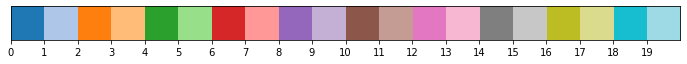

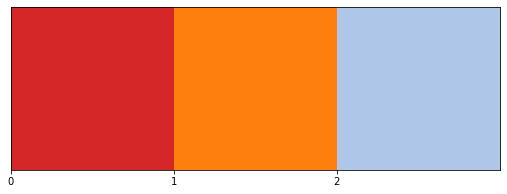

In [2]:
from matplotlib import colors

def plot_fig_label(ax, lab):
    ax.text(0, 1.1, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm
def view_colormap(cmap):
    """Plot a colormap"""
    if isinstance(cmap, str):
        cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])
    


    
view_colormap('tab20')

cm = makeCmap('tab20', [6, 2, 1])
view_colormap(cm)

# Prepare a class to parse the data

In [3]:
targets_df= pd.read_csv('../0_data/subset_targets.csv')
uniprots = pd.read_csv('uniprot_accessions.csv').drop_duplicates()
targets_df=targets_df.merge(uniprots, on=['chembl_id', 'pref_name']).drop(['year', 
                                                                           'canonical_smiles', 
                                                                           'lig_chemblid',
                                                                          'pchembl_value'],axis=1)


In [4]:
class pcv_load(object):

    def __init__(self, basedir):
        self.basedir = basedir
    def load_checkpoint(self):
        tar = tarfile.open('./'+self.basedir+'ligands.json.tar.gz')
        f = tar.extractfile('ligands.json')
        self.ligands = json.loads(f.read())

        self.targets = json.load(open('./'+self.basedir+'targets.json', 'r'))

        self.predictions = json.load(open('./'+self.basedir+'predictions.json', 'r'))
        
    def parse_predictions(self):
        df = pd.DataFrame(columns=['tid', 'pref_name', 'lig_chemblid', 'outcome', 'nnrank', 'prob', 'ligidx', 'targidx'])
        count = 0 
        for pred in tqdm.tqdm_notebook(self.predictions.keys()):
            lig, targ = pred.split(':')

            #target_synonyms = pcv.targets[targ]['synonyms']
            tid = self.targets[targ]['tid']
            pref_name = self.targets[targ]['pref_name']
            accession = self.targets[targ]['accession']
        
            ligand_chemblid = self.ligands[lig]['chemblid']
    
    
            #check if there are any active or inactive assays at all:
            actives = self.ligands[lig]['actives']
            inactives = self.ligands[lig]['inactives']
    
            num_actives = sum([1 if _==accession else 0 for _ in actives.values()])
            num_inactives = sum([1 if _==accession else 0 for _ in inactives.values()])
    
            nn = self.predictions[pred]['nn']
            prob = float(self.predictions[pred]['prob'])
    
            if (num_actives+num_inactives) > 0:
                for key, value in actives.items():
                    if accession in value:
                        df.loc[count] = [tid, pref_name, ligand_chemblid, 'Active', nn, prob, lig, targ]
                        count+=1
                for key, value in inactives.items():
                    if accession in value:
                        df.loc[count] = [tid, pref_name, ligand_chemblid, 'Inactive', nn, prob, lig, targ]
                        count+=1
        self.df = df
        
    def save(self):
        #save all raw data:
        self.df.sort_values(by='pref_name').to_csv(self.basedir+'/results.csv')
        
    def pivot_df(self):
        #aggregate the multiple assays for each protein-ligand pair into an 'active', 'inactive', or 'equal' record. 

        piv = self.df.pivot_table(index=['pref_name','lig_chemblid', 'prob', 'nnrank','ligidx','targidx'], 
               columns='outcome', 
               aggfunc='size', 
               fill_value=0)
        res = piv.reset_index()
        res['result'] = np.sign(res['Active'] - res['Inactive'])
        res['result'] = res['result'].apply(lambda x: {-1:'Inactive', 0:'Both', 1:'Active'}[x])
        result = res.drop('Active', axis=1).drop('Inactive', axis=1)
        result.reset_index(drop=True, inplace=True)#.head()
        self.result = result
        
    def count(self, rank):
        df_ = self.result[self.result['nnrank']>rank]
        pos = (df_['result']=='Active').sum()
        neg = (df_['result']=='Inactive').sum()
        return pos, neg
    
    def count_posi_and_nega(self, n=150):
        self.posi = np.zeros(n)
        self.nega = np.zeros(n)
        for i in range(1,n+1):
            pos, neg = self.count(i)
            self.posi[i-1]=pos
            self.nega[i-1]=neg
        self.tots = self.nega + self.posi

        

# Load up data and parse:

In [5]:
pcv_lightfm = pcv_load('processed_data/lightfm_warp/')
pcv_implicitbpr = pcv_load('./processed_data/implicit_bpr/')
pcv_labcorr = pcv_load('./processed_data/label_correlation/')
pcv_rf = pcv_load('./processed_data/random_forest/')
pcv_sea = pcv_load('./processed_data/sea/')

In [6]:
n = 250
pcv_lightfm.load_checkpoint()
pcv_lightfm.parse_predictions()
pcv_lightfm.pivot_df()
pcv_lightfm.count_posi_and_nega(n)

pcv_implicitbpr.load_checkpoint()
pcv_implicitbpr.parse_predictions()
pcv_implicitbpr.pivot_df()
pcv_implicitbpr.count_posi_and_nega(n)


pcv_labcorr.load_checkpoint()
pcv_labcorr.parse_predictions()
pcv_labcorr.pivot_df()
pcv_labcorr.count_posi_and_nega(n)

pcv_rf.load_checkpoint()
pcv_rf.parse_predictions()
pcv_rf.pivot_df()
pcv_rf.count_posi_and_nega(n)

pcv_sea.load_checkpoint()
pcv_sea.parse_predictions()
pcv_sea.pivot_df()
pcv_sea.count_posi_and_nega(n)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


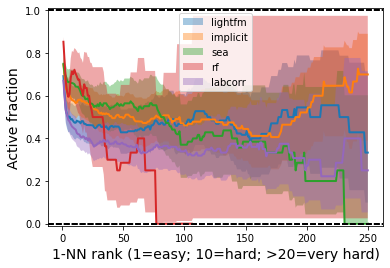

In [7]:
def plot_hit_fraction(pcv, ax, leg):
    fsize = 14
    rate = pcv.posi/ pcv.tots
    low = beta.ppf(0.025, pcv.posi+1, pcv.tots-pcv.posi+1)
    high =beta.ppf(0.975, pcv.posi+1, pcv.tots-pcv.posi+1)

    ax.fill_between(x=range(1,n+1),y1=low, y2=high,alpha=0.4, label=leg)
    ax.plot(range(1,n+1), rate, linewidth=2,)

    ax.set_ylabel('Active fraction',fontsize=fsize)
    ax.set_xlabel('1-NN rank (1=easy; 10=hard; >20=very hard)',fontsize=fsize)
    ax.set_ylim(bottom=-0.01,top=1.01)
    ax.axhline(0, linestyle='--', c='k')
    ax.axhline(1, linestyle='--', c='k')



fig, ax = plt.subplots()
plot_hit_fraction(pcv_lightfm, ax, 'lightfm')
plot_hit_fraction(pcv_implicitbpr, ax, 'implicit')
plot_hit_fraction(pcv_sea, ax, 'sea')
plot_hit_fraction(pcv_rf, ax, 'rf')
plot_hit_fraction(pcv_labcorr,ax, 'labcorr')
ax.legend()



In [8]:
def plot_proba(pcv, ax):
    fsize=13
    jit = np.random.random(len(pcv.result))-0.5
    jit /= 12
    jit += 1
    
    cax = ax.scatter(pcv.result['nnrank'].values*jit, 
            pcv.result['prob'].values.astype(float),
           c=pcv.result['result'].apply(lambda x: {'Active':1, 'Inactive':-1, 'Both':0}[x]),
           cmap = cm,
           alpha=0.7,
           edgecolor='k')
    ax.set_xscale('log')
    
    cbar = fig.colorbar(cax, ticks=[-0.66, 0, 0.66], ax=ax)
    cbar.ax.set_yticklabels(['Inactive', 'Both', 'Active'], fontsize=fsize) 

    ax.set_xlabel('log$_{10}}$(1-NN rank)', fontsize=fsize)
    ax.set_ylabel('Label correlation probability', fontsize=fsize)

    

In [9]:
# fig, ax = plt.subplots(2,2)
# fig.set_figwidth(15)
# fig.set_figheight(13)
# plot_proba(pcv_lightfm, ax[0,0])
# plot_proba(pcv_implicitbpr, ax[0,1])
# plot_proba(pcv_sea, ax[1,0])
# plot_proba(pcv_rf, ax[1,1])

# As altair:

## Proba vs score

In [10]:
def get_jitted_proba(pcv):
    jit = np.random.random(len(pcv.result))-0.5
    jit /= 12
    jit += 1
    
    return pcv.result['prob'].values.astype(float),pcv.result['nnrank'].values*jit, pcv.result['result']

res = {'Algorithm':[], 'Score':[], 'NN rank':[], 'Result':[]}

scores, nnranks, result = get_jitted_proba(pcv_lightfm)
for j, k, l in zip(scores, nnranks, result):
    res['Algorithm'].append('LightFM-WARP')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_implicitbpr)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Implicit-BPR')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_sea)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('SEA')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_rf)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Random Forest')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_labcorr)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Label correlation')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)

In [11]:
d = pd.DataFrame(res)

In [12]:

import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(d).mark_point().encode(
    y='Score:Q',
    x=alt.X('NN rank:Q'),# scale=alt.Scale(type='log'),),
    color='Result:N'
).properties(
    width=180,
    height=180
).facet(
   facet='Algorithm:N',
    columns=3
).resolve_scale(y='independent').configure_axis(
    #labelFontSize=14,
    titleFontSize=14 
).configure_header(
    titleFontSize=14,
    labelFontSize=14
)#.save('./figures/probability_vs_score.html')



alt.FacetChart(...)

## Rate vs nnrank:

In [13]:
def get_hit_fraction(pcv):

    rate = pcv.posi/ pcv.tots
    confint = proportion_confint(pcv.posi, pcv.tots, method='wilson')
    low= confint[0]
    high=confint[1]
    #low = beta.ppf(0.025, pcv.posi+1, pcv.tots-pcv.posi+1)
    #high =beta.ppf(0.975, pcv.posi+1, pcv.tots-pcv.posi+1)

    return rate, low, high

res = {'Algorithm':[], 'Rate':[], 'Low':[], 'High':[], 'NN rank':[]}


endrank = 250

rate, low, high = get_hit_fraction(pcv_lightfm)
for j, k, l, nn in zip(rate, low, high, range(1,endrank+1)):
    res['Algorithm'].append('LightFM-WARP')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_implicitbpr)
for j, k, l, nn in zip(rate, low, high, range(1,endrank+1)):
    res['Algorithm'].append('Implicit-BPR')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_sea)
for j, k, l, nn in zip(rate, low, high, range(1,endrank+1)):
    res['Algorithm'].append('SEA')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)

rate, low, high = get_hit_fraction(pcv_rf)
for j, k, l, nn in zip(rate, low, high, range(1,endrank+1)):
    res['Algorithm'].append('Random forest')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_labcorr)
for j, k, l, nn in zip(rate, low, high, range(1,endrank+1)):
    res['Algorithm'].append('Label correlation')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:135: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1 + crit2 / nobs
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:136: RuntimeWarning: divide by zero encountered in true_divide
  center = (q_ + crit2 / (2 * nobs)) / denom
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: divide by zero encountered in true_divide
  dist = cr

In [14]:
d = pd.DataFrame(res)

In [15]:
d[d['NN rank']==106] #107 is bad for rfc

,Algorithm,Rate,Low,High,NN rank
105,LightFM-WARP,0.487179,0.338652,0.638006,106
355,Implicit-BPR,0.468085,0.333317,0.607676,106
605,SEA,0.384615,0.224286,0.574651,106
855,Random forest,0.000000,0.000000,0.793451,106
1105,Label correlation,0.320000,0.207582,0.458103,106


In [17]:
line = alt.Chart(d).mark_line().encode(
    x=alt.X('NN rank',),#scale=alt.Scale(type='log'),),
    y=alt.Y('Rate', title='PubChem validation hit rate'),
    color=alt.Color('Algorithm')
)

band = line.mark_area(opacity=0.2).encode(
    x='NN rank',
    y=alt.Y('Low'),
    y2='High'
)

(band + line).properties(height=160, width=200).facet('Algorithm',columns=3).configure_axis(
    #labelFontSize=14,
    titleFontSize=14 
).configure_header(
    titleFontSize=14,
    labelFontSize=14
)#.save('./figures/hit_rate_vs_nn.html')



alt.FacetChart(...)

# Now repeat this figure, but mask out the predictions between protein subtypes.

There are 58,996 pairwise comparisons between the 344 proteins, so it's not feasible to check if each one looks like a subtype. 

Alternatively, there's a quick heuristic we can use. The string similarity between two names should be very high if they are subtypes (like `Adenosine A1 receptor` and `Adenosine A2a receptor`), and not so much if they are not subtypes (like `Adenosine A1 receptor` and `G-protein coupled receptor 55`). 

String similarity can be calculated with Jaro similarity which is normalized to [0,1].

The example above gives the Adenosine receptors a Jaro similarity of `0.9538239538239538`. The similarity to GPR55 has Jaro similarity `0.5993979200875753`


We would expect the vast majority of pairwise comparisons to be lower (close to `0.5`), and a small minority of pairwise comparisons come from subtypes (close to `0.9`).


In [18]:
from Levenshtein import distance as lev_distance
from Levenshtein import jaro as lev_jaro

n = len(targets_df)
jaro_matrix = np.zeros([n,n])


for j in tqdm.tqdm_notebook(range(n)):
    jlen = len(targets_df.iloc[j].pref_name)
    for k in range(n):
        #score = lev_distance(targets_df.iloc[j].sequence, targets_df.iloc[k].sequence)
        score = lev_jaro(targets_df.iloc[j].pref_name, targets_df.iloc[k].pref_name)
        jaro_matrix[j,k]=score

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


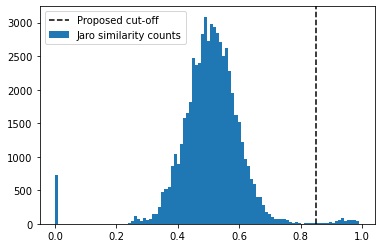

In [19]:
_=plt.hist(jaro_matrix[np.triu_indices(344,1)], bins=100, label='Jaro similarity counts')

cutoff = 0.85

plt.axvline(0.85, label='Proposed cut-off', c='k', linestyle='--')
plt.legend()

Find the highest Jaro similarity in the training set for each of the predictions made: 

In [21]:
#all labels:
from scipy import sparse
interaction_matrix = sparse.load_npz('../0_data/interaction_matrix_pchembl.npz')

for pcv in [pcv_implicitbpr, pcv_sea, pcv_rf, pcv_labcorr, pcv_lightfm]:
    nearest=list()
    for count, row in pcv.result.iterrows():
        lig_idx=int(row['ligidx'])
        targ_idx=int(row['targidx'])
        positives = interaction_matrix[lig_idx].nonzero()[1]
        nearest.append(jaro_matrix[targ_idx][positives].max())
    pcv.result['jaro']=nearest

plot:

In [23]:
def get_hit_fraction(pcv):

    n = 250
    posi = np.zeros(n)
    nega = np.zeros(n)
    df__ = pcv.result[pcv.result['jaro']<cutoff]

    for i in np.arange(1,n+1):

        df_ = df__[df__['nnrank']>i]

        pos = (df_['result']=='Active').sum()
        neg = (df_['result']=='Inactive').sum()
        posi[i-1]=pos
        nega[i-1]=neg
    tots = nega + posi
    
    rate = posi/ tots

    confint = proportion_confint(posi,tots,method='wilson')
    low = confint[0]
    high= confint[1]


    return rate, low, high

res = {'Algorithm':[], 'Rate':[], 'Low':[], 'High':[], 'NN rank':[]}


n = 250
rate, low, high = get_hit_fraction(pcv_lightfm)

for j, k, l, nn in zip(rate, low, high, np.arange(1, n+1)):
    res['Algorithm'].append('LightFM-WARP')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_implicitbpr)
for j, k, l, nn in zip(rate, low, high, np.arange(1, n+1)):
    res['Algorithm'].append('Implicit-BPR')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_sea)
for j, k, l, nn in zip(rate, low, high, np.arange(1, n+1)):
    res['Algorithm'].append('SEA')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)

rate, low, high = get_hit_fraction(pcv_rf)
for j, k, l, nn in zip(rate, low, high, np.arange(1, n+1)):
    res['Algorithm'].append('Random forest')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)
    
rate, low, high = get_hit_fraction(pcv_labcorr)
for j, k, l, nn in zip(rate, low, high, np.arange(1, n+1)):
    res['Algorithm'].append('Label correlation')
    res['Rate'].append(j)
    res['Low'].append(k)
    res['High'].append(l)
    res['NN rank'].append(nn)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:135: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1 + crit2 / nobs
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:136: RuntimeWarning: divide by zero encountered in true_divide
  center = (q_ + crit2 / (2 * nobs)) / denom
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: divide by zero encountered in true_divide
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


In [24]:
d = pd.DataFrame(res)

In [25]:
line = alt.Chart(d).mark_line().encode(
    x=alt.X('NN rank'),
    y=alt.Y('Rate', title='PubChem validation hit rate'),
    color=alt.Color('Algorithm')
)

band = line.mark_area(opacity=0.2).encode(
    x='NN rank',
    y=alt.Y('Low'),
    y2='High'
)

(band + line).properties(height=160, width=200).facet('Algorithm',columns=3).configure_axis(
    #labelFontSize=14,
    titleFontSize=14 
).configure_header(
    titleFontSize=14,
    labelFontSize=14
)

alt.FacetChart(...)

# Modelling of missing labels

In [26]:
activities = pcv_implicitbpr.df['outcome'].apply(lambda x: {'Active':1, 'Inactive':-1, 'Both':0}[x])
probabilities = pcv_implicitbpr.df['prob']
order_idx = np.argsort(probabilities)

activities_sorted = activities[order_idx]
probabilities_sorted = probabilities[order_idx]

In [37]:


import pymc3 as pm

with pm.Model() as first_model:
    #priors on parameters
    middle=pm.Normal('middle', mu=0,sigma=1000)
    
    slope=pm.Normal('slope', mu=0, sigma=1000)
    
    height = pm.Beta('height',2,2)

    
    #the probability of belonging to class 1
    p = height* pm.Deterministic('p', pm.math.sigmoid(middle+slope*probabilities_sorted))
    
    observed=pm.Bernoulli("occupancy", p, observed=np.clip(activities_sorted, 0, 1))
    
    trace=pm.sample(2000, tune=4000, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height, slope, middle]


Sampling 2 chains for 4_000 tune and 2_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<AxesSubplot:>

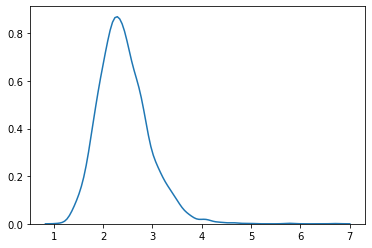

In [42]:

from seaborn import kdeplot
kdeplot(trace['slope'])
#kdeplot(trace['middle'])
#kdeplot(trace['height'])

In [43]:

bin_idx = np.digitize(probabilities_sorted, 
                      np.linspace(probabilities_sorted.min(), 
                                  probabilities_sorted.max(), 14)
                     )
max_bin=bin_idx.max()

xpt = []
ypt = []
low = []
high = []
for b in range(1,max_bin):
    mask=bin_idx==b
    success = activities_sorted[mask]
    score = probabilities_sorted[mask]
    
    numpos = (success>0).sum()
    numneg = (success<0).sum()
    
    rate = numpos/(numpos+numneg)
    
    ypt.append(rate)
    xpt.append(score.mean())
    confint = proportion_confint(numpos, numpos+numneg, method='wilson')
    
    low.append(confint[0])
    high.append(confint[1])

In [94]:

from altair import expr, datum

x = np.linspace(-2,6,50)
line_source = pd.DataFrame({'Score':x})

base = alt.Chart(line_source).mark_line(color='gray',opacity=0.2).encode(
    x=alt.X('Score:Q', title='Score'),
    y=alt.Y('Hit rate:Q', title='Hit rate'),
)#.properties(height=250, width=350)

lines = []
for i in range(100):
    sample_idx = np.random.choice(trace['height'].shape[0])
    height = trace['height'][sample_idx] 
    slope = trace['slope'][sample_idx]
    middle = trace['middle'][sample_idx]
    lines.append(base.transform_calculate(
        as_='Hit rate',
        calculate=height * 1/ ( 1 + expr.exp(-middle - datum.Score * slope))))
    
    
point_source = pd.DataFrame({'Score':xpt, 'Hit rate':ypt, 'low':low, 'high':high})

points = alt.Chart(point_source).mark_point(
    filled=True,
    color='black'
).encode(
    x=alt.X('Score:Q'),
    y=alt.Y('Hit rate:Q',),

)
error_bars = points.mark_rule().encode(
    y=alt.Y('low:Q', title=' '),
    y2='high:Q',
    
)
  
ch = (alt.layer(base, *lines)+ points+error_bars)
ch
#ch.title = 'Implicit-BPR '

alt.LayerChart(...)

In [48]:
ch.save('./figures/implicti-bpr_bayesian_fit.html')

# Estimate the total number of missing labels using Implicit-BPR

In [49]:
import sys
sys.path.append("..")
import utils
params = utils.read_params('hpo_implicit_bpr')



/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [55]:
probability_matrix = utils.train_implicit_bpr(params, interaction_matrix)

#set probabilities of known hits to zero:
probability_matrix[interaction_matrix.toarray()==1] = 0

In [68]:
num_predicted = list()

for i in tqdm.tqdm_notebook(range(200)):
    sample_idx = np.random.choice(trace['slope'].shape[0])
    ntot=(trace['height'][sample_idx] * expit(trace['middle'][sample_idx] \
                                              + probability_matrix*trace['slope'][sample_idx]))*trace['height'][sample_idx]

    
    numpos = (np.random.random(ntot.shape) < ntot).sum() 
    num_predicted.append(numpos)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
pm.hpd(np.array(num_predicted))

array([1748267, 7626898])

In [79]:
mat = sparse.csr_matrix(np.random.random(ntot.shape) < ntot)+interaction_matrix

In [87]:
np.array(interaction_matrix.sum(1).flatten())[0]

array([31.,  1.,  1., ...,  2.,  2.,  3.])

In [84]:
nligs = np.array(mat.sum(1)).flatten()

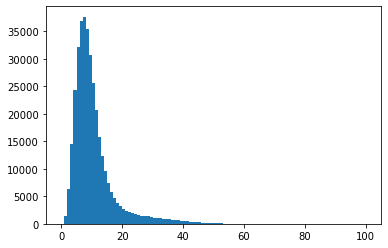

In [91]:
_ = plt.hist(nligs, bins=np.arange(nligs.max()))

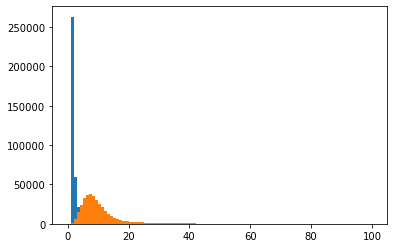

In [93]:
nligs_orig = np.array(interaction_matrix.sum(1).flatten())[0]
_ = plt.hist(nligs_orig, bins=np.arange(nligs_orig.max()))
_ = plt.hist(nligs, bins=np.arange(nligs.max()))

(array([2.45447e+05, 8.59550e+04, 1.64360e+04, 7.88700e+03, 2.54400e+03,
        5.18000e+02, 1.06000e+02, 3.10000e+01, 9.00000e+00, 5.00000e+00]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.]),
 <BarContainer object of 10 artists>)

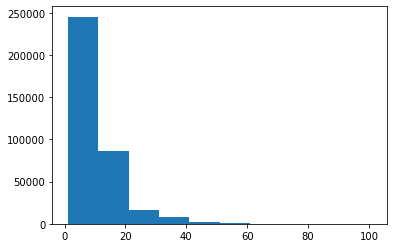

In [82]:
plt.hist(np.array(mat.sum(1)).flatten(), )

# sequence similarity

In [205]:
targets_sequences = pd.read_csv('../0_data/target_sequences.csv').drop_duplicates()
targets_df=targets_df.merge(targets_sequences, on=['chembl_id', 'pref_name'])

In [206]:
blosum50 = \
    {
        '*': {'*': 1, 'A': -5, 'C': -5, 'B': -5, 'E': -5, 'D': -5, 'G': -5,
              'F': -5, 'I': -5, 'H': -5, 'K': -5, 'M': -5, 'L': -5,
              'N': -5, 'Q': -5, 'P': -5, 'S': -5, 'R': -5, 'T': -5,
              'W': -5, 'V': -5, 'Y': -5, 'X': -5, 'Z': -5},
        'A': {'*': -5, 'A': 5, 'C': -1, 'B': -2, 'E': -1, 'D': -2, 'G': 0,
              'F': -3, 'I': -1, 'H': -2, 'K': -1, 'M': -1, 'L': -2,
              'N': -1, 'Q': -1, 'P': -1, 'S': 1, 'R': -2, 'T': 0, 'W': -3,
              'V': 0, 'Y': -2, 'X': -1, 'Z': -1},
        'C': {'*': -5, 'A': -1, 'C': 13, 'B': -3, 'E': -3, 'D': -4,
              'G': -3, 'F': -2, 'I': -2, 'H': -3, 'K': -3, 'M': -2,
              'L': -2, 'N': -2, 'Q': -3, 'P': -4, 'S': -1, 'R': -4,
              'T': -1, 'W': -5, 'V': -1, 'Y': -3, 'X': -1, 'Z': -3},
        'B': {'*': -5, 'A': -2, 'C': -3, 'B': 6, 'E': 1, 'D': 6, 'G': -1,
              'F': -4, 'I': -4, 'H': 0, 'K': 0, 'M': -3, 'L': -4, 'N': 5,
              'Q': 0, 'P': -2, 'S': 0, 'R': -1, 'T': 0, 'W': -5, 'V': -3,
              'Y': -3, 'X': -1, 'Z': 1},
        'E': {'*': -5, 'A': -1, 'C': -3, 'B': 1, 'E': 6, 'D': 2, 'G': -3,
              'F': -3, 'I': -4, 'H': 0, 'K': 1, 'M': -2, 'L': -3, 'N': 0,
              'Q': 2, 'P': -1, 'S': -1, 'R': 0, 'T': -1, 'W': -3, 'V': -3,
              'Y': -2, 'X': -1, 'Z': 5},
        'D': {'*': -5, 'A': -2, 'C': -4, 'B': 6, 'E': 2, 'D': 8, 'G': -1,
              'F': -5, 'I': -4, 'H': -1, 'K': -1, 'M': -4, 'L': -4, 'N': 2,
              'Q': 0, 'P': -1, 'S': 0, 'R': -2, 'T': -1, 'W': -5, 'V': -4,
              'Y': -3, 'X': -1, 'Z': 1},
        'G': {'*': -5, 'A': 0, 'C': -3, 'B': -1, 'E': -3, 'D': -1, 'G': 8,
              'F': -4, 'I': -4, 'H': -2, 'K': -2, 'M': -3, 'L': -4, 'N': 0,
              'Q': -2, 'P': -2, 'S': 0, 'R': -3, 'T': -2, 'W': -3, 'V': -4,
              'Y': -3, 'X': -1, 'Z': -2},
        'F': {'*': -5, 'A': -3, 'C': -2, 'B': -4, 'E': -3, 'D': -5,
              'G': -4, 'F': 8, 'I': 0, 'H': -1, 'K': -4, 'M': 0, 'L': 1,
              'N': -4, 'Q': -4, 'P': -4, 'S': -3, 'R': -3, 'T': -2, 'W': 1,
              'V': -1, 'Y': 4, 'X': -1, 'Z': -4},
        'I': {'*': -5, 'A': -1, 'C': -2, 'B': -4, 'E': -4, 'D': -4,
              'G': -4, 'F': 0, 'I': 5, 'H': -4, 'K': -3, 'M': 2, 'L': 2,
              'N': -3, 'Q': -3, 'P': -3, 'S': -3, 'R': -4, 'T': -1,
              'W': -3, 'V': 4, 'Y': -1, 'X': -1, 'Z': -3},
        'H': {'*': -5, 'A': -2, 'C': -3, 'B': 0, 'E': 0, 'D': -1, 'G': -2,
              'F': -1, 'I': -4, 'H': 10, 'K': 0, 'M': -1, 'L': -3, 'N': 1,
              'Q': 1, 'P': -2, 'S': -1, 'R': 0, 'T': -2, 'W': -3, 'V': -4,
              'Y': 2, 'X': -1, 'Z': 0},
        'K': {'*': -5, 'A': -1, 'C': -3, 'B': 0, 'E': 1, 'D': -1, 'G': -2,
              'F': -4, 'I': -3, 'H': 0, 'K': 6, 'M': -2, 'L': -3, 'N': 0,
              'Q': 2, 'P': -1, 'S': 0, 'R': 3, 'T': -1, 'W': -3, 'V': -3,
              'Y': -2, 'X': -1, 'Z': 1},
        'M': {'*': -5, 'A': -1, 'C': -2, 'B': -3, 'E': -2, 'D': -4,
              'G': -3, 'F': 0, 'I': 2, 'H': -1, 'K': -2, 'M': 7, 'L': 3,
              'N': -2, 'Q': 0, 'P': -3, 'S': -2, 'R': -2, 'T': -1, 'W': -1,
              'V': 1, 'Y': 0, 'X': -1, 'Z': -1},
        'L': {'*': -5, 'A': -2, 'C': -2, 'B': -4, 'E': -3, 'D': -4,
              'G': -4, 'F': 1, 'I': 2, 'H': -3, 'K': -3, 'M': 3, 'L': 5,
              'N': -4, 'Q': -2, 'P': -4, 'S': -3, 'R': -3, 'T': -1,
              'W': -2, 'V': 1, 'Y': -1, 'X': -1, 'Z': -3},
        'N': {'*': -5, 'A': -1, 'C': -2, 'B': 5, 'E': 0, 'D': 2, 'G': 0,
              'F': -4, 'I': -3, 'H': 1, 'K': 0, 'M': -2, 'L': -4, 'N': 7,
              'Q': 0, 'P': -2, 'S': 1, 'R': -1, 'T': 0, 'W': -4, 'V': -3,
              'Y': -2, 'X': -1, 'Z': 0},
        'Q': {'*': -5, 'A': -1, 'C': -3, 'B': 0, 'E': 2, 'D': 0, 'G': -2,
              'F': -4, 'I': -3, 'H': 1, 'K': 2, 'M': 0, 'L': -2, 'N': 0,
              'Q': 7, 'P': -1, 'S': 0, 'R': 1, 'T': -1, 'W': -1, 'V': -3,
              'Y': -1, 'X': -1, 'Z': 4},
        'P': {'*': -5, 'A': -1, 'C': -4, 'B': -2, 'E': -1, 'D': -1,
              'G': -2, 'F': -4, 'I': -3, 'H': -2, 'K': -1, 'M': -3,
              'L': -4, 'N': -2, 'Q': -1, 'P': 10, 'S': -1, 'R': -3,
              'T': -1, 'W': -4, 'V': -3, 'Y': -3, 'X': -1, 'Z': -1},
        'S': {'*': -5, 'A': 1, 'C': -1, 'B': 0, 'E': -1, 'D': 0, 'G': 0,
              'F': -3, 'I': -3, 'H': -1, 'K': 0, 'M': -2, 'L': -3, 'N': 1,
              'Q': 0, 'P': -1, 'S': 5, 'R': -1, 'T': 2, 'W': -4, 'V': -2,
              'Y': -2, 'X': -1, 'Z': 0},
        'R': {'*': -5, 'A': -2, 'C': -4, 'B': -1, 'E': 0, 'D': -2, 'G': -3,
              'F': -3, 'I': -4, 'H': 0, 'K': 3, 'M': -2, 'L': -3, 'N': -1,
              'Q': 1, 'P': -3, 'S': -1, 'R': 7, 'T': -1, 'W': -3, 'V': -3,
              'Y': -1, 'X': -1, 'Z': 0},
        'T': {'*': -5, 'A': 0, 'C': -1, 'B': 0, 'E': -1, 'D': -1, 'G': -2,
              'F': -2, 'I': -1, 'H': -2, 'K': -1, 'M': -1, 'L': -1, 'N': 0,
              'Q': -1, 'P': -1, 'S': 2, 'R': -1, 'T': 5, 'W': -3, 'V': 0,
              'Y': -2, 'X': -1, 'Z': -1},
        'W': {'*': -5, 'A': -3, 'C': -5, 'B': -5, 'E': -3, 'D': -5,
              'G': -3, 'F': 1, 'I': -3, 'H': -3, 'K': -3, 'M': -1, 'L': -2,
              'N': -4, 'Q': -1, 'P': -4, 'S': -4, 'R': -3, 'T': -3,
              'W': 15, 'V': -3, 'Y': 2, 'X': -1, 'Z': -2},
        'V': {'*': -5, 'A': 0, 'C': -1, 'B': -3, 'E': -3, 'D': -4, 'G': -4,
              'F': -1, 'I': 4, 'H': -4, 'K': -3, 'M': 1, 'L': 1, 'N': -3,
              'Q': -3, 'P': -3, 'S': -2, 'R': -3, 'T': 0, 'W': -3, 'V': 5,
              'Y': -1, 'X': -1, 'Z': -3},
        'Y': {'*': -5, 'A': -2, 'C': -3, 'B': -3, 'E': -2, 'D': -3,
              'G': -3, 'F': 4, 'I': -1, 'H': 2, 'K': -2, 'M': 0, 'L': -1,
              'N': -2, 'Q': -1, 'P': -3, 'S': -2, 'R': -1, 'T': -2, 'W': 2,
              'V': -1, 'Y': 8, 'X': -1, 'Z': -2},
        'X': {'*': -5, 'A': -1, 'C': -1, 'B': -1, 'E': -1, 'D': -1,
              'G': -1, 'F': -1, 'I': -1, 'H': -1, 'K': -1, 'M': -1,
              'L': -1, 'N': -1, 'Q': -1, 'P': -1, 'S': -1, 'R': -1,
              'T': -1, 'W': -1, 'V': -1, 'Y': -1, 'X': -1, 'Z': -1},
        'Z': {'*': -5, 'A': -1, 'C': -3, 'B': 1, 'E': 5, 'D': 1, 'G': -2,
              'F': -4, 'I': -3, 'H': 0, 'K': 1, 'M': -1, 'L': -3, 'N': 0,
              'Q': 4, 'P': -1, 'S': 0, 'R': 0, 'T': -1, 'W': -2, 'V': -3,
              'Y': -2, 'X': -1, 'Z': 5}}

In [172]:
L = utils.makeCorrelations(interaction_matrix).toarray()

  0%|          | 147/95750 [00:00<01:05, 1467.34it/s]

y_in shape is: (358938, 344)


100%|██████████| 95750/95750 [00:33<00:00, 2883.60it/s]


In [462]:
from skbio.alignment import StripedSmithWaterman

n = len(targets_df)
score_matrix = np.zeros([n,n])

for j in tqdm.tqdm_notebook(range(n)):
    ssw = StripedSmithWaterman(targets_df.iloc[j].sequence, protein=True, substitution_matrix=blosum50)
    jlen = len(targets_df.iloc[j].sequence)
    for k in range(n):
        score = ssw(targets_df.iloc[k].sequence)['optimal_alignment_score']
        score_matrix[j,k]=score / jlen
        
        

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [497]:
def get_jitted_proba(pcv):
    jit = np.random.random(len(pcv.result))-0.5
    jit /= 12
    jit += 1
    
    return pcv.result['nn_sequence'].values.astype(float),pcv.result['nnrank'].values*jit, pcv.result['result']

res = {'Algorithm':[], 'Score':[], 'NN rank':[], 'Result':[]}

scores, nnranks, result = get_jitted_proba(pcv_lightfm)
for j, k, l in zip(scores, nnranks, result):
    res['Algorithm'].append('LightFM-WARP')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_implicitbpr)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Implicit-BPR')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_sea)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('SEA')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_rf)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Random Forest')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)
    
scores, nnranks, result = get_jitted_proba(pcv_labcorr)
for j, k,l in zip(scores, nnranks, result):
    res['Algorithm'].append('Label correlation')
    res['Score'].append(j)
    res['NN rank'].append(k)
    res['Result'].append(l)

In [498]:
d = pd.DataFrame(res)
import altair as alt
alt.data_transformers.disable_max_rows()
alt.Chart(d).mark_point().encode(
    y=alt.Y('Score:Q',),#, scale=alt.Scale(type='log'),),
    x=alt.X('NN rank:Q',scale=alt.Scale(type='log'),),
    color='Result:N'
).properties(
    width=180,
    height=180
).facet(
   facet='Algorithm:N',
    columns=3
).resolve_scale(y='independent').configure_axis(
    #labelFontSize=14,
    titleFontSize=14 
).configure_header(
    titleFontSize=14,
    labelFontSize=14
).interactive()#.save('./figures/probability_vs_score.html')



alt.FacetChart(...)

In [62]:
import sys
sys.path.append("..")
import utils
params = utils.read_params('hpo_implicit_bpr')


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [243]:
probability_matrix = utils.train_implicit_bpr(params, interaction_matrix)


In [247]:
ntot=(trace['height'].mean() * expit(trace['beta_0'].mean() + probability_matrix*trace['beta_temp'].mean()))*trace['height'].mean()




In [390]:
ntot = (trace['height'][sample_idx] * expit(trace['beta_0'][sample_idx] \
                                              + probability_matrix*trace['beta_temp'][sample_idx]))*trace['height'][sample_idx]



In [394]:
m = (np.random.random(ntot.shape) < ntot).sum(1)

<AxesSubplot:>

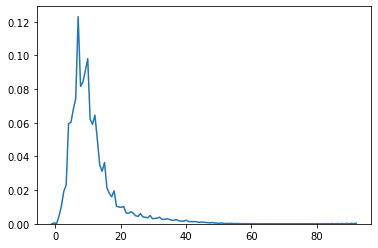

In [398]:
kdeplot(m)

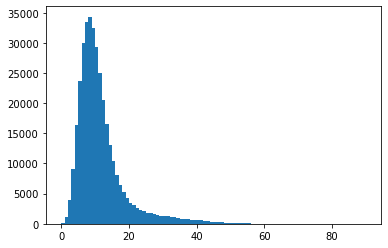

In [399]:
_=plt.hist(m,bins=np.arange(m.max()))

In [448]:
m_ = np.array(interaction_matrix.sum(1).flatten())
#_=plt.hist(m_, bins=np.arange(m_.max()))

In [449]:
m_

array([[31.,  1.,  1., ...,  2.,  2.,  3.]])

In [305]:
unknowns = probability_matrix[interaction_matrix.toarray()==0]

In [309]:
#numpos=list()
for i in tqdm.tqdm_notebook(range(200)):
    sample_idx = np.random.choice(trace['beta_0'].shape[0])
    ntot=(trace['height'][sample_idx] * expit(trace['beta_0'][sample_idx] \
                                              + unknowns*trace['beta_temp'][sample_idx]))*trace['height'][sample_idx]

    
    numpo = (np.random.random(ntot.shape) < ntot).sum() 
    numpos.append(numpo)
    
    

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

In [313]:
pm.hpd(np.array(numpos)) / probability_matrix.shape[0]



/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


array([ 3.73522447, 22.11083808])

<AxesSubplot:>

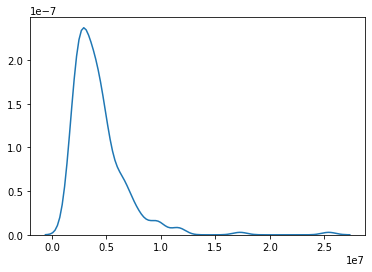

In [310]:
kdeplot(numpos)

<AxesSubplot:>

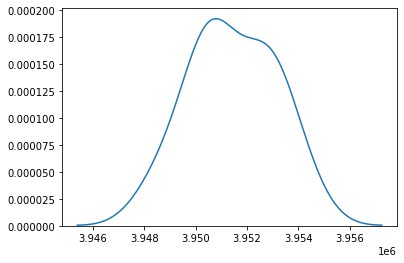

In [265]:
ntot=(trace['height'].mean() * expit(trace['beta_0'].mean() + probability_matrix*trace['beta_temp'].mean()))*trace['height'].mean()


### 

# Plotting target types:

In [408]:
import altair as alt

def parse_groups(group):
    inactive = group['outcome'].str.contains('Inactive').sum()
    active = group['outcome'].str.contains('Active').sum()
    if (active - inactive) > 0:
        return 'Active'
    if (active - inactive) < 0:
        return 'Inactive'
    else:
        return 'Both'

collapse the assay data into per-ligand-target-pair results (i.e. `active`, `inactive`, `equal`).

Here also have the opportunity to select a protein family classification. 


In [413]:
targets_df

,chembl_id,l1,pref_name,accession
0,CHEMBL1075104,Enzyme,Leucine-rich repeat serine/threonine-protein k...,Q5S007
1,CHEMBL1075138,Enzyme,Tyrosyl-DNA phosphodiesterase 1,Q9NUW8
2,CHEMBL1075189,Enzyme,Pyruvate kinase isozymes M1/M2,P14618
3,CHEMBL1075322,Membrane receptor,G-protein coupled receptor 55,Q9Y2T6
4,CHEMBL1293194,Enzyme,"Carnitine O-palmitoyltransferase 1, liver isoform",P50416
...,...,...,...,...
344,CHEMBL6009,Enzyme,Diacylglycerol O-acyltransferase 1,O75907
345,CHEMBL6115,Enzyme,Lysosomal protective protein,P10619
346,CHEMBL6154,Enzyme,Tankyrase-2,Q9H2K2
347,CHEMBL6164,Enzyme,Tankyrase-1,O95271


In [418]:
filtered_df=pcv_implicitbpr.df.merge(targets_df, on='pref_name')
types

array(['Enzyme', 'Membrane receptor', 'Ion channel'], dtype=object)

In [423]:
def parse_data(df, classification, lim=None):
    if lim is not None:
        df = df.groupby('pref_name').filter(lambda x : len(x)>lim)

    filtered_df = df.merge(targets_df , on='pref_name')
    out = filtered_df[filtered_df['l1'].isin(classification)].groupby(['lig_chemblid', 'pref_name']).apply(parse_groups)

    out_df= pd.DataFrame(out).reset_index().drop('lig_chemblid',axis=1)

    out_df.columns=['pref_name', 'activity']
    return out_df
 
    

#Mask 1-NN solutions:
#out = df[df['nnrank']>0].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

types = filtered_df.l1.unique()
t = types[2]
print(t)

parse_data(pcv_implicitbpr.df, [types[0]])


Ion channel


,pref_name,activity
0,Caspase-6,Active
1,Caspase-7,Active
2,Caspase-7,Active
3,Caspase-6,Active
4,Cytochrome P450 2C9,Active
...,...,...
527,Mitogen-activated protein kinase kinase kinase...,Inactive
528,Plasminogen,Active
529,Matrix metalloproteinase-1,Active
530,Cathepsin B,Active


In [433]:
probability_matrix.shape

(358938, 344)

In [437]:
targets_df[targets_df['l1']=='Ion channel']

,chembl_id,l1,pref_name,accession
9,CHEMBL1293292,Ion channel,ATP-sensitive inward rectifier potassium chann...,P48048
37,CHEMBL1899,Ion channel,Serotonin 3a (5-HT3a) receptor,P46098
57,CHEMBL1980,Ion channel,Sodium channel protein type V alpha subunit,Q14524
114,CHEMBL2321613,Ion channel,Potassium channel subfamily K member 3,O14649
126,CHEMBL240,Ion channel,HERG,Q12809
137,CHEMBL2492,Ion channel,Neuronal acetylcholine receptor protein alpha-...,P36544
193,CHEMBL2998,Ion channel,P2X purinoceptor 3,P56373
230,CHEMBL3572,Ion channel,Cholesteryl ester transfer protein,P11597
282,CHEMBL4296,Ion channel,Sodium channel protein type IX alpha subunit,Q15858
283,CHEMBL4306,Ion channel,Voltage-gated potassium channel subunit Kv1.5,P22460


In [439]:



def make_altair_long(df):
    ch = alt.Chart(df).mark_bar()

    ch = ch.encode(
        y = alt.Y('pref_name', sort='-x', title='Count'),
        x = alt.X('count()', title='Count'),
        color=alt.Color('activity'),
        order=alt.Order('activity', sort='ascending'),
        tooltip=['count()',]).properties(height=550,width=350).configure_axisY(
        titleFontSize=13,
            ).configure_axisX(
            titleFontSize=13
            ).configure_axisBottom(labelAngle=-35).configure_header(
                titleFontSize=40, 
                labelFontSize=40
            ).configure_axisY(
                titleAngle=0,
                titleAlign="left",
                titleY=-10,
                titleX=-20,
                titleFontSize=16,
            ).configure_legend(orient='bottom',labelFontSize=22)
    
    return ch



#make_altair_long(parse_data(df, [types[0]], 0))
make_altair_long(parse_data(pcv_implicitbpr.df, types[1:], 0))

alt.Chart(...)

In [442]:
make_altair_long(parse_data(pcv_implicitbpr.df, [types[0]], 3))

alt.Chart(...)

In [1866]:
def make_altair_wide(df, h=200, w=650):
    ch = alt.Chart(df).mark_bar()

    ch = ch.encode(
        x = alt.X('pref_name', sort='-y', title='Target preferred name'),
        y = alt.Y('count()'),
        color=alt.Color('activity'),
        order=alt.Order('activity', sort='ascending'),
    ).properties(height=h,width=w).configure_axisX(labelAngle=40)
    return ch

ch1 = make_altair_wide(parse_data(df, [types[0]], 5))
ch2 = make_altair_wide(parse_data(df, [types[4]], 0), h=150, w=400)
ch3 = make_altair_wide(parse_data(df, types, 10), h=200, w=750)


In [1867]:
ch1

alt.Chart(...)

In [1868]:
ch2

alt.Chart(...)

In [1420]:
ch2.save('./figures/receptors'

alt.Chart(...)

In [1423]:
ch3.save('./figures/all_target_classes.html')

In [991]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>2)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=500,width=300)

# ch.configure_axisY(
# titleFontSize=13,
# ).configure_axisX(
# titleFontSize=13
# ).configure_axisBottom(labelAngle=-35).configure_header(
#     titleFontSize=40, 
#     labelFontSize=40
# ).configure_axisY(
#     titleAngle=0,
#     titleAlign="left",
#     titleY=-10,
#     titleX=-20,
#     titleFontSize=16,
# ).configure_legend(orient='bottom',labelFontSize=22)

ch

alt.Chart(...)

In [1350]:
ch = alt.Chart(out_df).mark_bar()

ch = ch.encode(
    x = alt.X('pref_name', sort='-y', title='Target preferred name'),
    y = alt.Y('count()'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=200,width=750).configure_axisX(labelAngle=40)
ch



alt.Chart(...)

# Getting target classes:

In [894]:
target_types = pd.read_csv('target_classes.csv')

In [895]:
target_types

,chembl_id,l1,l2,l3,pref_name
0,CHEMBL3568,Enzyme,NaN,NaN,"Nitric-oxide synthase, brain"
1,CHEMBL2963,Enzyme,Protease,Metallo protease,Matrix metalloproteinase 15
2,CHEMBL2227,Ion channel,Other ion channel,Pore-forming toxins (proteins and peptides),Proenkephalin B
3,CHEMBL5208,Transporter,Electrochemical transporter,SLC superfamily of solute carriers,GABA transporter 3
4,CHEMBL3338,Enzyme,NaN,NaN,Squalene synthetase
...,...,...,...,...,...
3148,CHEMBL3989381,Unclassified protein,NaN,NaN,Hepcidin
3149,CHEMBL3989382,Unclassified protein,NaN,NaN,Macrophage colony-stimulating factor 1
3150,CHEMBL3989383,Unclassified protein,NaN,NaN,Tumor necrosis factor receptor superfamily mem...
3151,CHEMBL3989384,Unclassified protein,NaN,NaN,Cadherin-3


In [896]:
df.merge(target_types, on='pref_name')

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank,chembl_id,l1,l2,l3
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5,CHEMBL261,Enzyme,Lyase,NaN
1,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Enzyme,Lyase,NaN
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215276,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Enzyme,Lyase,NaN
3,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,47713,Active,inhibition of human carbonic anhydrase i cai,2.0,CHEMBL261,Enzyme,Lyase,NaN
4,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,50367,Active,inhibitory activity against human carbonic anh...,2.0,CHEMBL261,Enzyme,Lyase,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2105,CHEMBL1914,Butyrylcholinesterase,CHEMBL3604192,1240923,Active,inhibition of equine serum bche using atc iodi...,1.0,CHEMBL1914,Enzyme,Hydrolase,NaN
2106,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase
2107,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase
2108,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344881,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase


In [1456]:
from chembl_webresource_client.new_client import new_client 
target = new_client.target
tid = 'CHEMBL204'
res = target.filter(target_chembl_id=tid)
res

[{'cross_references': [{'xref_id': 'P00734', 'xref_name': None, 'xref_src': 'canSAR-Target'}, {'xref_id': 'Thrombin', 'xref_name': None, 'xref_src': 'Wikipedia'}], 'organism': 'Homo sapiens', 'pref_name': 'Thrombin', 'species_group_flag': False, 'target_chembl_id': 'CHEMBL204', 'target_components': [{'accession': 'P00734', 'component_description': 'Prothrombin', 'component_id': 92, 'component_type': 'PROTEIN', 'relationship': 'SINGLE PROTEIN', 'target_component_synonyms': [{'component_synonym': '3.4.21.5', 'syn_type': 'EC_NUMBER'}, {'component_synonym': 'Activation peptide fragment 1', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Activation peptide fragment 2', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Coagulation factor II', 'syn_type': 'UNIPROT'}, {'component_synonym': 'F2', 'syn_type': 'GENE_SYMBOL'}, {'component_synonym': 'Prothrombin', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Thrombin heavy chain', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Thrombin light chain', 